# HyperGrid Rewards: Visualizing Modes on a 3D Grid (D=2, H=256)

This notebook visualizes several `GridReward` definitions from `gfn.gym.hypergrid` on a 3D surface over the 2D grid with height H=256. For each reward schema, we:

- define the mathematical form of the reward and the resulting mode set,
- compute the reward over the full grid \(X = \{0,\dots,H-1\}^2\),
- render a 3D surface of the reward landscape, and
- overlay markers for states classified as "modes" using the environment's mode threshold.

For each environment we also report:
- the total number of distinct modes (`env.n_modes`), and
- the fraction of grid states that are modes.

We keep \(H=256\) across all rewards to allow apples-to-apples comparisons. If a preset is too sparse or unreachable at this resolution, we tweak its parameters slightly to ensure that modes are visible.

In [1]:
import itertools
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused (needed for 3D)
from matplotlib import cm
from gfn.gym.hypergrid import HyperGrid, get_reward_presets

plt.style.use("seaborn-v0_8")

D = 2
H = 256  # common height for all plots


def build_env(reward_name: str, kwargs: dict, validate_modes: bool = True, ndim: int | None = None):
    nd = D if ndim is None else int(ndim)
    return HyperGrid(
        ndim=nd,
        height=H,
        reward_fn_str=reward_name,
        reward_fn_kwargs=kwargs,
        validate_modes=validate_modes,
        store_all_states=False,
    )


def grid_points_2d_slice(H: int, ndim: int, fixed: list[int] | None = None):
    xs = torch.arange(H)
    base = torch.cartesian_prod(xs, xs)  # (H*H, 2)
    if ndim <= 2:
        return base
    if fixed is None:
        fixed = [0] * (ndim - 2)
    assert len(fixed) == (ndim - 2)
    tail = torch.tensor(fixed, dtype=torch.long).unsqueeze(0).expand(base.shape[0], -1)
    return torch.cat([base, tail], dim=1)


def sample_points_nd(H: int, ndim: int, num_samples: int) -> torch.Tensor:
    # Uniform random sample of integer grid points in [0, H-1]^ndim
    return torch.randint(0, H, (num_samples, ndim), dtype=torch.long)


def _normalize01(x: torch.Tensor) -> torch.Tensor:
    x = x.to(dtype=torch.get_default_dtype())
    xmin = float(x.min().item())
    xmax = float(x.max().item())
    if xmax <= xmin + 1e-12:
        return torch.zeros_like(x, dtype=torch.get_default_dtype())
    return (x - xmin) / (xmax - xmin)


def plot_reward_3d(ax, title, rewards, modes_mask, cmap_name: str = "Blues", vmin: float | None = None, vmax: float | None = None, H: int | None = None):

    # Determine grid height for reshaping and axes
    HH = int(H) if H is not None else int(round(float(rewards.numel()) ** 0.5))

    # rewards shape: (HH*HH,)
    Z_t = rewards.view(HH, HH).to(dtype=torch.get_default_dtype())
    Z = Z_t.cpu().numpy()

    # Auto-scale if vmin/vmax not provided (previous behavior)
    if vmin is None or vmax is None:
        flat = Z_t.flatten()
        nz = flat[flat > 0]
        if nz.numel() >= 10:
            vmin_auto = float(torch.quantile(nz, 0.05).item())
            vmax_auto = float(torch.quantile(nz, 0.995).item())
            if vmax_auto <= vmin_auto + 1e-12:
                vmin_auto = float(nz.min().item())
                vmax_auto = float(nz.max().item())
        else:
            vmin_auto = float(flat.min().item())
            vmax_auto = float(flat.max().item())
        if vmin is None:
            vmin = vmin_auto
        if vmax is None:
            vmax = vmax_auto

    norm = Normalize(vmin=vmin, vmax=vmax)

    X, Y = np.meshgrid(np.arange(HH), np.arange(HH))
    ax.plot_surface(X, Y, Z, cmap=plt.get_cmap(cmap_name), norm=norm, linewidth=0, antialiased=True, alpha=0.9)
    # Overlay modes as red points slightly above surface
    mm = modes_mask.view(HH, HH).cpu().numpy()
    yy, xx = np.where(mm)
    if len(xx) > 0:
        ax.scatter(xx, yy, Z[yy, xx] + 1e-6, s=4, c="red", marker="o", label="modes", depthshade=False)
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("reward")
    # Put a compact legend if any modes
    if len(xx) > 0:
        ax.legend(loc="upper right", fontsize=8)


def plot_pointcloud_3d(
    ax,
    title: str,
    pts: torch.Tensor,
    rewards: torch.Tensor,
    cmap_name: str = "viridis",
    min_quantile: float = 0.02,
    max_quantile: float = 0.995,
    gamma: float = 0.5,
    zero_epsilon: float = 1e-12,
    min_nonzero_alpha: float = 0.01,
    min_nonzero_size: float = 12.0,
):
    # pts: (N,3) long, rewards: (N,)
    vals_t = rewards.to(dtype=torch.get_default_dtype()).clamp_min(0)

    # Quantile-based compression over non-zero rewards so low-but-nonzero are visible
    nz_mask_t = vals_t > zero_epsilon
    nz = vals_t[nz_mask_t]
    if nz.numel() >= 5:
        vmin = float(torch.quantile(nz, min_quantile).item())
        vmax = float(torch.quantile(nz, max_quantile).item())
    else:
        vmin = float(vals_t.min().item())
        vmax = float(vals_t.max().item())
    if not (vmax > vmin):
        vmax = vmin + 1e-6

    vals = ((vals_t - vmin) / (vmax - vmin)).clamp(0.0, 1.0)
    # Gamma to brighten low values while keeping highs distinct
    vals_np = torch.pow(vals, gamma).cpu().numpy()

    # Sizes and colors
    s_min, s_max = 6.0, 26.0
    sizes = s_min + (s_max - s_min) * vals_np
    cmap = plt.get_cmap(cmap_name)
    colors = cmap(vals_np)
    alpha_min, alpha_max = 0.01, 0.5
    alphas = alpha_min + (alpha_max - alpha_min) * vals_np

    # Make exact zeros transparent
    zeros_mask = (vals_t <= zero_epsilon).cpu().numpy()
    alphas[zeros_mask] = 0.0

    # Ensure nonzero points have minimum visibility (handles discrete rewards like MultiplicativeCoprime)
    nz_mask = nz_mask_t.cpu().numpy()
    alphas[nz_mask] = np.maximum(alphas[nz_mask], float(min_nonzero_alpha))
    sizes[nz_mask] = np.maximum(sizes[nz_mask], float(min_nonzero_size))

    colors[:, 3] = alphas

    x = pts[:, 0].cpu().numpy()
    y = pts[:, 1].cpu().numpy()
    z = pts[:, 2].cpu().numpy()
    ax.scatter(x, y, z, c=colors, s=sizes, marker="o", depthshade=True)
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")


def plot_pointcloud_rungs_3d(
    ax,
    title: str,
    pts: torch.Tensor,
    rung_ids: torch.Tensor,
    rewards: torch.Tensor | None = None,
    tab_cmap = cm.get_cmap("tab10"),
    non_rung_rgba = (0.7, 0.7, 0.7, 0.15),
    min_quantile: float = 0.02,
    max_quantile: float = 0.995,
    gamma: float = 0.5,
    zero_epsilon: float = 1e-12,
    min_nonzero_alpha: float = 0.01,
    min_nonzero_size: float = 12.0,
):
    # Determine alpha/size from rewards if provided; otherwise use defaults
    if rewards is not None:
        vals_t = rewards.to(dtype=torch.get_default_dtype()).clamp_min(0)
        nz_mask_t = vals_t > zero_epsilon
        nz = vals_t[nz_mask_t]
        if nz.numel() >= 5:
            vmin = float(torch.quantile(nz, min_quantile).item())
            vmax = float(torch.quantile(nz, max_quantile).item())
        else:
            vmin = float(vals_t.min().item())
            vmax = float(vals_t.max().item())
        if not (vmax > vmin):
            vmax = vmin + 1e-6
        vals = ((vals_t - vmin) / (vmax - vmin)).clamp(0.0, 1.0)
        vals_np = torch.pow(vals, gamma).cpu().numpy()
        s_min, s_max = 6.0, 26.0
        sizes = s_min + (s_max - s_min) * vals_np
        alpha_min, alpha_max = 0.01, 0.5
        alphas = alpha_min + (alpha_max - alpha_min) * vals_np
        zeros_mask = (vals_t <= zero_epsilon).cpu().numpy()
        alphas[zeros_mask] = 0.0
        nz_mask = nz_mask_t.cpu().numpy()
        alphas[nz_mask] = np.maximum(alphas[nz_mask], float(min_nonzero_alpha))
        sizes[nz_mask] = np.maximum(sizes[nz_mask], float(min_nonzero_size))
    else:
        N = pts.shape[0]
        sizes = np.full(N, 10.0, dtype=np.float32)
        alphas = np.full(N, 0.5, dtype=np.float32)

    # Build colors by rung id while preserving computed alpha
    N = pts.shape[0]
    colors = np.zeros((N, 4), dtype=np.float32)
    # Initialize as non-rung
    colors[:] = non_rung_rgba
    for t in range(min(10, 1 + int(rung_ids.max().item()) if rung_ids.numel() > 0 else 0)):
        mask = (rung_ids == t).cpu().numpy()
        if np.any(mask):
            rgba = np.array(tab_cmap(t % 10), dtype=np.float32)
            colors[mask, :3] = rgba[:3]
    # Apply alpha from alphas array for all points
    colors[:, 3] = np.maximum(colors[:, 3], alphas.astype(np.float32))

    x = pts[:, 0].cpu().numpy()
    y = pts[:, 1].cpu().numpy()
    z = pts[:, 2].cpu().numpy()
    ax.scatter(x, y, z, c=colors, s=sizes, marker="o", depthshade=True)
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")


def compute_rewards_and_modes(env: HyperGrid, pts: torch.Tensor):
    rewards = env.reward(env.States(pts))  # shape (N,)
    mask = env.mode_mask(env.States(pts))  # shape (N,)
    return rewards, mask


def summarize_modes(env: HyperGrid, mask: torch.Tensor, label: str = ""):
    prefix = (label + ": ") if label else ""
    n_modes_distinct = env.n_modes
    frac_modes = float(mask.float().mean().item())
    print(f"{prefix}n_modes (distinct): {n_modes_distinct}")
    print(f"{prefix}% of plotted grid states that are modes: {100.0 * frac_modes:.4f}%")



/var/folders/hd/jqxc7ns56l35q_zyk7xmptmw0000gn/T/ipykernel_49317/3565857304.py:166: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab_cmap = cm.get_cmap("tab10"),


## Original Reward

The Original reward (Bengio et al., 2021) is
\[
R(x) = R_0 \; + \; R_1 \; \prod_{i=1}^D \mathbf{1}[0.25 < a_i(x) \le 0.5] \; + \; R_2 \; \prod_{i=1}^D \mathbf{1}[0.3 < a_i(x) < 0.4],
\]
where
\[ a_i(x) = \left| \frac{x_i}{H-1} - \tfrac{1}{2} \right|. \]
Modes are the thin band where both products equal 1 (outer ring and inner band).


/Users/jdv/code/torchgfn/src/gfn/env.py:495: UserWarning: You're using advanced parameters: (sf). These are only needed for custom action handling. For basic environments, you can omit these.
  warnings.warn(


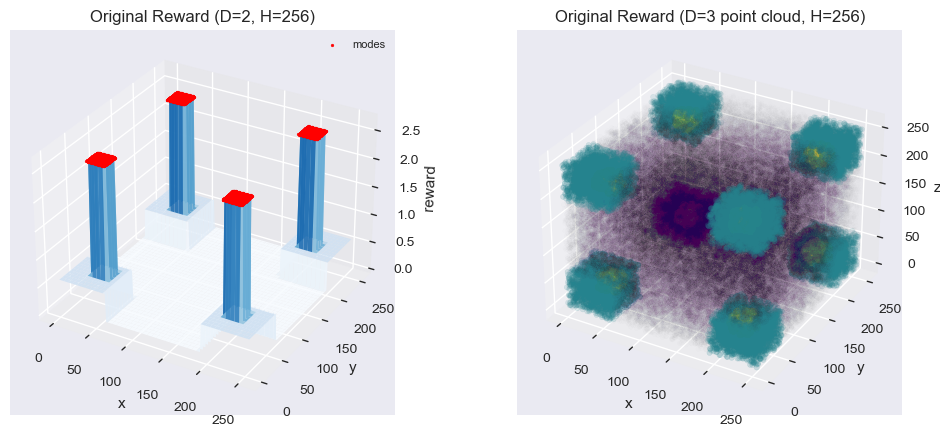

D=2: n_modes (distinct): 4
D=2: % of plotted grid states that are modes: 3.8147%
D=3 (point cloud): n_modes (distinct): 8
D=3 (point cloud): % of plotted grid states that are modes: 0.7635%


In [2]:
orig_kwargs = dict(R0=0.1, R1=0.5, R2=2.0)

# D=2
orig_env2 = build_env("original", orig_kwargs, validate_modes=True, ndim=2)
pts2 = grid_points_2d_slice(H, 2)
orig_rewards2, orig_modes2 = compute_rewards_and_modes(orig_env2, pts2)

# D=3 (plot a 2D slice at z=0)
orig_env3 = build_env("original", orig_kwargs, validate_modes=False, ndim=3)
pts3 = grid_points_2d_slice(H, 3, fixed=[0])
orig_rewards3, orig_modes3 = compute_rewards_and_modes(orig_env3, pts3)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection="3d")
plot_reward_3d(ax1, "Original Reward (D=2, H={})".format(H), orig_rewards2, orig_modes2, H=H)
ax2 = fig.add_subplot(122, projection="3d")
# D=3 point cloud: sample points and size/alpha by reward
pts3_pc = sample_points_nd(H, 3, num_samples=200000)
rewards3_pc, _ = compute_rewards_and_modes(orig_env3, pts3_pc)
plot_pointcloud_3d(ax2, "Original Reward (D=3 point cloud, H={})".format(H), pts3_pc, rewards3_pc)
plt.show()

summarize_modes(orig_env2, orig_modes2, label="D=2")
# For point cloud, report fraction of sampled points that are modes
mask3_pc = orig_env3.mode_mask(orig_env3.States(pts3_pc))
summarize_modes(orig_env3, mask3_pc, label="D=3 (point cloud)")


## Deceptive Reward

The Deceptive reward is
\[
R(x) = (R_0 + R_1) \; - \; R_1 \; \prod_{i=1}^D \mathbf{1}[0.1 < a_i(x)] \; + \; R_2 \; \prod_{i=1}^D \mathbf{1}[0.3 < a_i(x) < 0.4].
\]
Compared to Original, the outer region cancels \(R_1\), the center keeps \(R_1\), and the band still adds \(R_2\). Modes lie on the thin band.


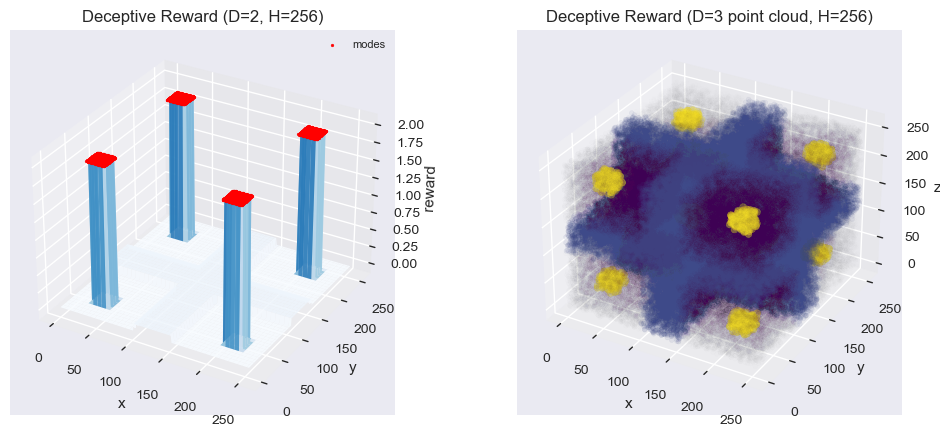

D=2: n_modes (distinct): 4
D=2: % of plotted grid states that are modes: 3.8147%
D=3 (point cloud): n_modes (distinct): 8
D=3 (point cloud): % of plotted grid states that are modes: 0.7110%


In [3]:
dec_kwargs = dict(R0=1e-5, R1=0.1, R2=2.0)

# D=2
dec_env2 = build_env("deceptive", dec_kwargs, validate_modes=True, ndim=2)
pts2 = grid_points_2d_slice(H, 2)
dec_rewards2, dec_modes2 = compute_rewards_and_modes(dec_env2, pts2)

# D=3 slice
dec_env3 = build_env("deceptive", dec_kwargs, validate_modes=False, ndim=3)
pts3 = grid_points_2d_slice(H, 3, fixed=[0])
dec_rewards3, dec_modes3 = compute_rewards_and_modes(dec_env3, pts3)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection="3d")
plot_reward_3d(ax1, "Deceptive Reward (D=2, H={})".format(H), dec_rewards2, dec_modes2, H=H)
ax2 = fig.add_subplot(122, projection="3d")
pts3_pc = sample_points_nd(H, 3, num_samples=200000)
rewards3_pc, _ = compute_rewards_and_modes(dec_env3, pts3_pc)
plot_pointcloud_3d(ax2, "Deceptive Reward (D=3 point cloud, H={})".format(H), pts3_pc, rewards3_pc)
plt.show()

summarize_modes(dec_env2, dec_modes2, label="D=2")
mask3_pc = dec_env3.mode_mask(dec_env3.States(pts3_pc))
summarize_modes(dec_env3, mask3_pc, label="D=3 (point cloud)")


## Cosine Reward

Let \(a_i(x) = |x_i/(H-1) - 1/2|\). Define
\[
R(x) = R_0 + R_1 \prod_{i=1}^D \big( (\cos(50\, a_i(x)) + 1) \cdot \tfrac{1}{\sqrt{2\pi}} e^{-\tfrac{1}{2} (5\,a_i(x))^2} \big).
\]
Modes correspond to the product being near its peak; the mode threshold uses a \(\gamma\)-scaled per-dimension peak.


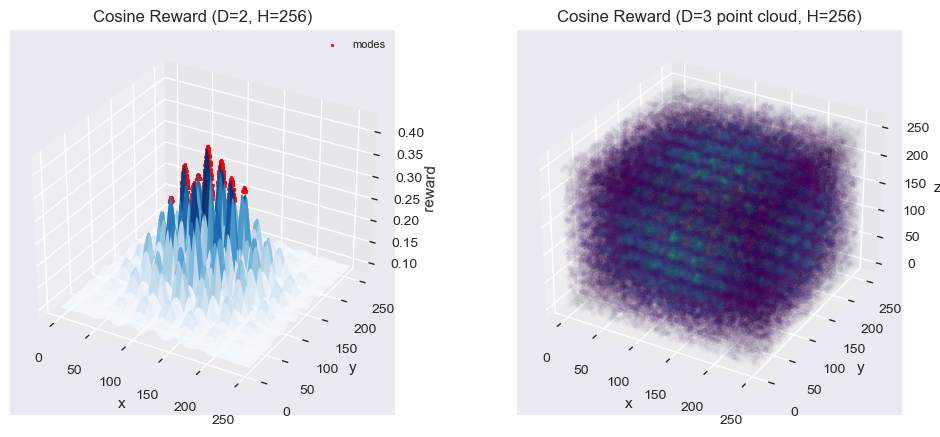

D=2: n_modes (distinct): 4
D=2: % of plotted grid states that are modes: 0.8301%
D=3 (point cloud): n_modes (distinct): 8
D=3 (point cloud): % of plotted grid states that are modes: 0.1040%


In [4]:
cos_kwargs = dict(R0=0.1, R1=0.5, mode_gamma=0.8)

# D=2
cos_env2 = build_env("cosine", cos_kwargs, validate_modes=True, ndim=2)
pts2 = grid_points_2d_slice(H, 2)
cos_rewards2, cos_modes2 = compute_rewards_and_modes(cos_env2, pts2)

# D=3 slice
cos_env3 = build_env("cosine", cos_kwargs, validate_modes=False, ndim=3)
pts3 = grid_points_2d_slice(H, 3, fixed=[0])
cos_rewards3, cos_modes3 = compute_rewards_and_modes(cos_env3, pts3)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection="3d")
plot_reward_3d(ax1, "Cosine Reward (D=2, H={})".format(H), cos_rewards2, cos_modes2, H=H)
ax2 = fig.add_subplot(122, projection="3d")
pts3_pc = sample_points_nd(H, 3, num_samples=200000)
rewards3_pc, _ = compute_rewards_and_modes(cos_env3, pts3_pc)
plot_pointcloud_3d(
    ax2,
    "Cosine Reward (D=3 point cloud, H={})".format(H),
    pts3_pc,
    rewards3_pc,
)
plt.show()

summarize_modes(cos_env2, cos_modes2, label="D=2")
mask3_pc = cos_env3.mode_mask(cos_env3.States(pts3_pc))
summarize_modes(cos_env3, mask3_pc, label="D=3 (point cloud)")


## Sparse Reward (GAFN paper)

Targets are constructed by taking, for each \(k \in \{0,\dots,D\}\), all distinct permutations of a vector with \(k\) ones and \(D-k\) entries equal to \(H-2\). The reward is
\[
R(x) = \sum_{t \in T} \mathbf{1}[x = t] + \varepsilon, \quad \varepsilon > 0,
\]
which yields extremely sparse spikes at known locations.


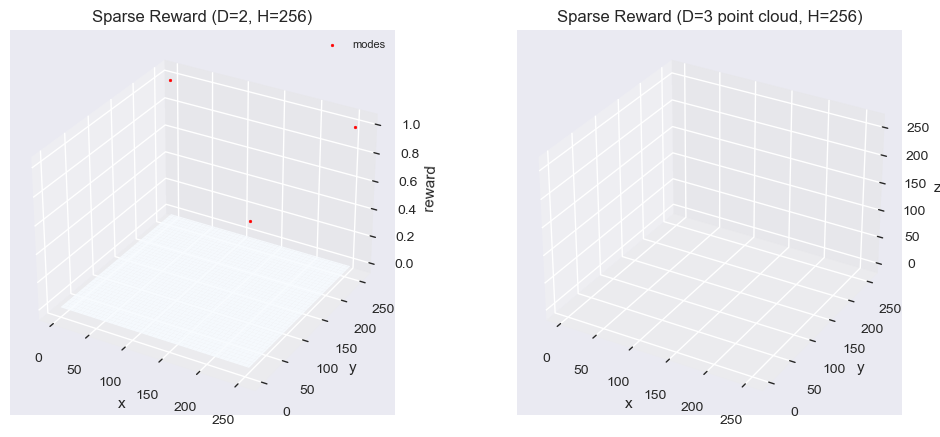

D=2: n_modes (distinct): 4
D=2: % of plotted grid states that are modes: 0.0046%
D=3 (point cloud): n_modes (distinct): 8
D=3 (point cloud): % of plotted grid states that are modes: 0.0000%


In [5]:
sparse_kwargs = {}

# D=2
sparse_env2 = build_env("sparse", sparse_kwargs, validate_modes=True, ndim=2)
pts2 = grid_points_2d_slice(H, 2)
sparse_rewards2, sparse_modes2 = compute_rewards_and_modes(sparse_env2, pts2)

# D=3 slice
sparse_env3 = build_env("sparse", sparse_kwargs, validate_modes=False, ndim=3)
pts3 = grid_points_2d_slice(H, 3, fixed=[0])
sparse_rewards3, sparse_modes3 = compute_rewards_and_modes(sparse_env3, pts3)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection="3d")
plot_reward_3d(ax1, "Sparse Reward (D=2, H={})".format(H), sparse_rewards2, sparse_modes2, H=H)
ax2 = fig.add_subplot(122, projection="3d")
pts3_pc = sample_points_nd(H, 3, num_samples=200000)
rewards3_pc, _ = compute_rewards_and_modes(sparse_env3, pts3_pc)
plot_pointcloud_3d(ax2, "Sparse Reward (D=3 point cloud, H={})".format(H), pts3_pc, rewards3_pc)
plt.show()

summarize_modes(sparse_env2, sparse_modes2, label="D=2")
mask3_pc = sparse_env3.mode_mask(sparse_env3.States(pts3_pc))
summarize_modes(sparse_env3, mask3_pc, label="D=3 (point cloud)")


## Bitwise/XOR Reward (compositional)

We constrain bit-planes over GF(2). For tier \(t\) with bit window \([\ell_t, h_t]\), let
\(u^{(b)} \in \{0,1\}^m\) be the bits at plane \(b\) across constrained dims; enforce
\(A_t u^{(b)} \equiv c_t \; (\text{mod } 2)\) or even parity if unspecified. Reward tiers add when all constraints up to tier-\(t\) hold.


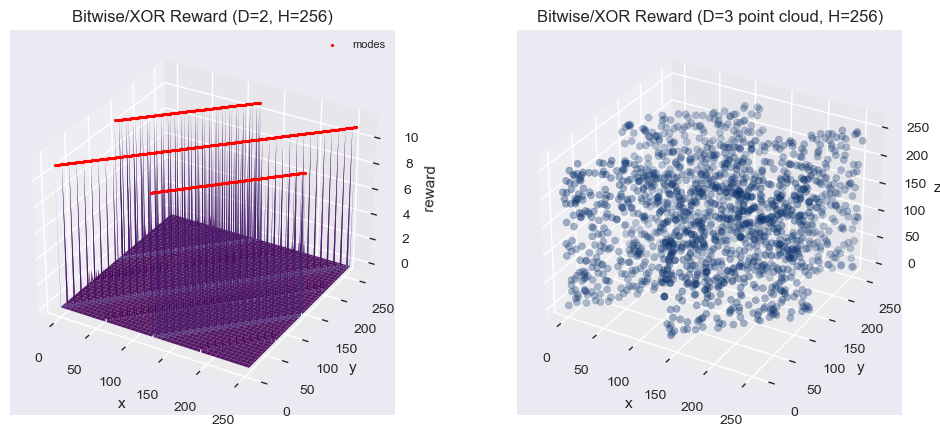

D=2: n_modes (distinct): 4
D=2: % of plotted grid states that are modes: 0.7812%
D=3 (point cloud): n_modes (distinct): 8
D=3 (point cloud): % of plotted grid states that are modes: 0.7615%


In [6]:
xor_kwargs = get_reward_presets("bitwise_xor", D, H)["easy"].copy()
# Use moderate constraints to render clearly at H=256
xor_kwargs.update(dict(dims_constrained=[0, 1], bits_per_tier=[(0, 5), (0, 6)], tier_weights=[1.0, 10.0]))

# D=2
xor_env2 = build_env("bitwise_xor", xor_kwargs, validate_modes=True, ndim=2)
pts2 = grid_points_2d_slice(H, 2)
xor_rewards2, xor_modes2 = compute_rewards_and_modes(xor_env2, pts2)

# D=3 slice
xor_env3 = build_env("bitwise_xor", xor_kwargs, validate_modes=False, ndim=3)
pts3 = grid_points_2d_slice(H, 3, fixed=[0])
xor_rewards3, xor_modes3 = compute_rewards_and_modes(xor_env3, pts3)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection="3d")
plot_reward_3d(
    ax1,
    "Bitwise/XOR Reward (D=2, H={})".format(H),
    xor_rewards2,
    xor_modes2,
    vmin=0,
    cmap_name="viridis",
    H=H,
)
ax2 = fig.add_subplot(122, projection="3d")
pts3_pc = sample_points_nd(H, 3, num_samples=200000)
rewards3_pc, _ = compute_rewards_and_modes(xor_env3, pts3_pc)
plot_pointcloud_3d(
    ax2,
    "Bitwise/XOR Reward (D=3 point cloud, H={})".format(H),
    pts3_pc,
    rewards3_pc,
    cmap_name="Blues",
)
plt.show()
summarize_modes(xor_env2, xor_modes2, label="D=2")
mask3_pc = xor_env3.mode_mask(xor_env3.States(pts3_pc))
summarize_modes(xor_env3, mask3_pc, label="D=3 (point cloud)")


## Multiplicative/Coprime Reward (compositional)

Per-dimension values must factor over a small prime set with bounded exponents (cap per tier), plus optional cross-dimension coprimality and LCM targets. Reward tiers add when constraints up to tier-\(t\) hold.


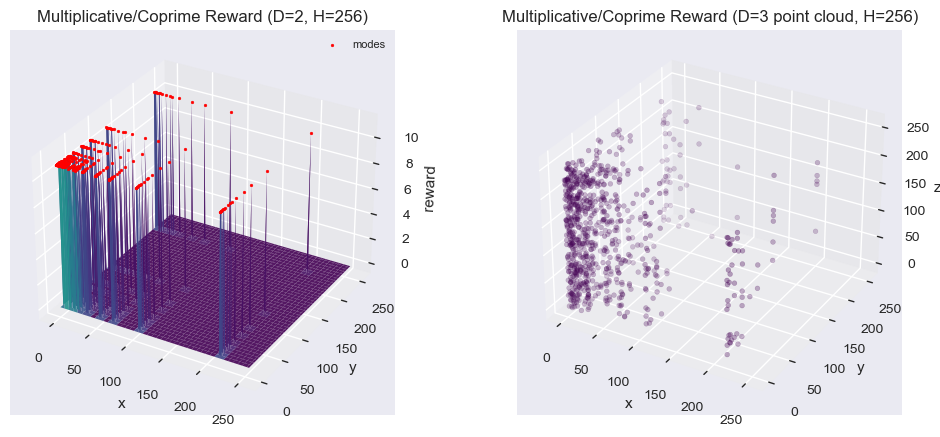

D=2: n_modes (distinct): 4
D=2: % of plotted grid states that are modes: 0.3906%
D=3 (point cloud): n_modes (distinct): 8
D=3 (point cloud): % of plotted grid states that are modes: 0.3985%


In [7]:
mc_kwargs = dict(R0=0.0, tier_weights=[1.0, 10.0], primes=[2, 3], exponent_caps=[3, 3], active_dims=[0, 1])

# D=2
mc_env2 = build_env("multiplicative_coprime", mc_kwargs, validate_modes=True, ndim=2)
pts2 = grid_points_2d_slice(H, 2)
mc_rewards2, mc_modes2 = compute_rewards_and_modes(mc_env2, pts2)

# D=3 slice
mc_env3 = build_env("multiplicative_coprime", mc_kwargs, validate_modes=False, ndim=3)
pts3 = grid_points_2d_slice(H, 3, fixed=[0])
mc_rewards3, mc_modes3 = compute_rewards_and_modes(mc_env3, pts3)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection="3d")
plot_reward_3d(
    ax1,
    "Multiplicative/Coprime Reward (D=2, H={})".format(H),
    mc_rewards2,
    mc_modes2,
    vmin=0,
    cmap_name="viridis",
    H=H,
)
ax2 = fig.add_subplot(122, projection="3d")
pts3_pc = sample_points_nd(H, 3, num_samples=200000)
rewards3_pc, _ = compute_rewards_and_modes(mc_env3, pts3_pc)
plot_pointcloud_3d(
    ax2,
    "Multiplicative/Coprime Reward (D=3 point cloud, H={})".format(H),
    pts3_pc,
    rewards3_pc,
    min_quantile=0.02,
    max_quantile=0.7,
    gamma=0.25,
    min_nonzero_alpha=0.4,
)
plt.show()

summarize_modes(mc_env2, mc_modes2, label="D=2")
mask3_pc = mc_env3.mode_mask(mc_env3.States(pts3_pc))
summarize_modes(mc_env3, mask3_pc, label="D=3 (point cloud)")


## Template Minkowski Reward (compositional)

We gate by thin L1 radius bands per tier. For tier \(t\) with band \([r_t^{\min}, r_t^{\max}]\), we add \(w_t\) if \(r_t^{\min} \le \|x\|_1 \le r_t^{\max}\) (and optional sum-residue). Tiers are non-cumulative here; modes correspond to the highest achievable band.


Available presets: dict_keys(['easy', 'easy_crt_dims', 'medium', 'medium_dir', 'hard', 'hard_cumulative', 'challenging', 'challenging_mix', 'impossible'])


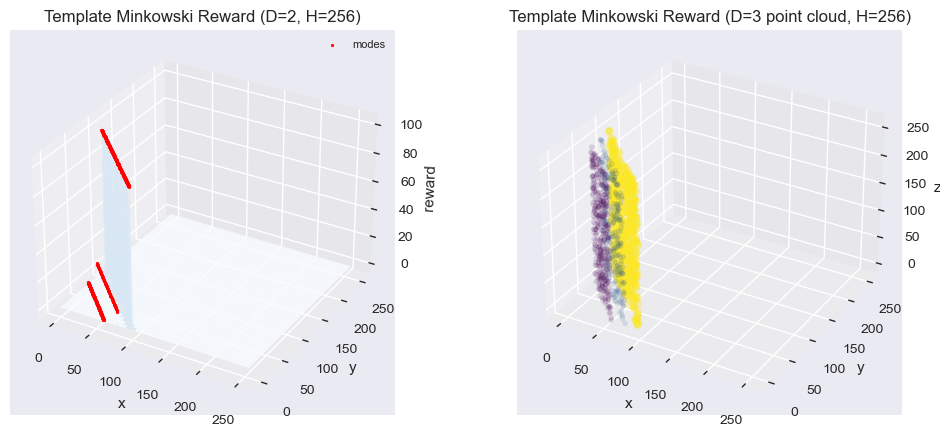

D=2: n_modes (distinct): 4
D=2: % of plotted grid states that are modes: 0.6180%
D=3 (point cloud): n_modes (distinct): 8
D=3 (point cloud): % of plotted grid states that are modes: 0.6190%


In [8]:
print(
    "Available presets: {}".format(
        get_reward_presets("template_minkowski", D, H).keys()
    )
)
tm_kwargs = get_reward_presets("template_minkowski", D, H)["hard"].copy()
# Keep bands thin and reachable at H=256

# D=2
tm_env2 = build_env("template_minkowski", tm_kwargs, validate_modes=True, ndim=2)
pts2 = grid_points_2d_slice(H, 2)
tm_rewards2, tm_modes2 = compute_rewards_and_modes(tm_env2, pts2)

# D=3 slice
# Align dims_subset with directional vector length (2) in the preset
tm_kwargs3 = tm_kwargs.copy()
tm_kwargs3["dims_subset"] = [0, 1]
tm_env3 = build_env("template_minkowski", tm_kwargs3, validate_modes=False, ndim=3)
pts3 = grid_points_2d_slice(H, 3, fixed=[0])
tm_rewards3, tm_modes3 = compute_rewards_and_modes(tm_env3, pts3)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection="3d")
plot_reward_3d(ax1, "Template Minkowski Reward (D=2, H={})".format(H), tm_rewards2, tm_modes2, H=H)
ax2 = fig.add_subplot(122, projection="3d")
pts3_pc = sample_points_nd(H, 3, num_samples=200000)
rewards3_pc, _ = compute_rewards_and_modes(tm_env3, pts3_pc)
plot_pointcloud_3d(
    ax2,
    "Template Minkowski Reward (D=3 point cloud, H={})".format(H),
    pts3_pc,
    rewards3_pc,
    min_quantile=0.02,
    max_quantile=0.9,
    gamma=0.5,
    min_nonzero_alpha=0.2,
)
plt.show()

summarize_modes(tm_env2, tm_modes2, label="D=2")
mask3_pc = tm_env3.mode_mask(tm_env3.States(pts3_pc))
summarize_modes(tm_env3, mask3_pc, label="D=3 (point cloud)")


/var/folders/hd/jqxc7ns56l35q_zyk7xmptmw0000gn/T/ipykernel_49317/1700074172.py:109: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc="upper right", fontsize=8, ncols=2)


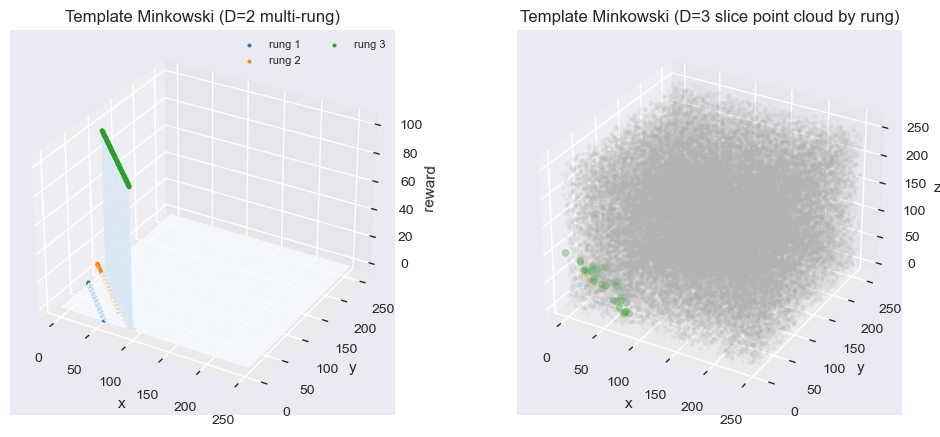

In [9]:
# Visualize Template Minkowski with multi-rung overlays (3D)

def plot_template_minkowski_multi_rung_3d(D: int, H: int):
    # Choose a preset demonstrating richer structure
    tm_kwargs_crt = get_reward_presets("template_minkowski", D, H)["hard"].copy()

    # D=2 setup
    tm_env2 = build_env("template_minkowski", tm_kwargs_crt, validate_modes=True, ndim=2)
    pts2 = grid_points_2d_slice(H, 2)
    x2 = pts2.index_select(dim=-1, index=torch.tensor(tm_env2.reward_fn.dims_subset))
    l1_2 = x2.to(dtype=torch.get_default_dtype()).sum(dim=-1)
    rewards2, _ = compute_rewards_and_modes(tm_env2, pts2)

    # D=3 setup (full 3D point cloud via sampling)
    tm_env3 = build_env("template_minkowski", tm_kwargs_crt, validate_modes=True, ndim=3)
    pts3 = sample_points_nd(H, 3, num_samples=200000)
    x3 = pts3.index_select(dim=-1, index=torch.tensor(tm_env3.reward_fn.dims_subset))
    l1_3 = x3.to(dtype=torch.get_default_dtype()).sum(dim=-1)
    rewards3, _ = compute_rewards_and_modes(tm_env3, pts3)

    r_bands = tm_kwargs_crt["r_bands"]
    sum_mods = tm_kwargs_crt.get("sum_mods", [None] * len(r_bands))
    dims_mods = tm_kwargs_crt.get("dims_mods", [None] * len(r_bands))
    dir_bands = tm_kwargs_crt.get("dir_bands", [None] * len(r_bands))

    fig = plt.figure(figsize=(12, 5))
    ax1 = fig.add_subplot(121, projection="3d")
    plot_reward_3d(ax1, "Template Minkowski (D=2 multi-rung)", rewards2, torch.zeros_like(l1_2, dtype=torch.bool), H=H)
    ax2 = fig.add_subplot(122, projection="3d")
    # Right panel: point cloud on the D=3 slice, colored by rung index
    rung_id = torch.full_like(l1_3, fill_value=-1, dtype=torch.long)

    colors = [cm.tab10(i) for i in range(len(r_bands))]
    Z2 = rewards2.view(H, H).cpu().numpy()
    #Z3 = rewards3.view(H, H).cpu().numpy()

    # overlay rungs for D=2
    for t, (rmin, rmax) in enumerate(r_bands):
        band_ok = (l1_2 >= float(rmin)) & (l1_2 <= float(rmax))
        mod_ok = torch.ones_like(band_ok)
        if sum_mods[t] is not None:
            mod, tgt = sum_mods[t]
            mod_ok = (l1_2.long() % int(mod)) == int(tgt)
        dims_ok = torch.ones_like(band_ok)
        if dims_mods and dims_mods[t] is not None:
            for (dim, m, a) in dims_mods[t]:
                vals = pts2[..., int(dim)]
                dims_ok = dims_ok & ((vals.long() % int(m)) == int(a))
        dir_ok = torch.ones_like(band_ok)
        if dir_bands and dir_bands[t] is not None:
            v = torch.tensor(dir_bands[t].get("v", []), dtype=torch.get_default_dtype())
            if v.numel() == len(tm_env2.reward_fn.dims_subset):
                x_for_dir = x2.to(dtype=torch.get_default_dtype())
            else:
                x_for_dir = pts2.to(dtype=torch.get_default_dtype())
            dot = (x_for_dir * v).sum(dim=-1)
            lo = float(dir_bands[t].get("lo", -1e9))
            hi = float(dir_bands[t].get("hi", 1e9))
            dir_ok = (dot >= lo) & (dot <= hi)
        rung_mask = (band_ok & mod_ok & dims_ok & dir_ok).view(H, H).cpu().numpy()
        yy, xx = np.where(rung_mask)
        if len(xx) > 0:
            ax1.scatter(xx, yy, Z2[yy, xx] + 1e-6, s=6, c=[colors[t]], marker="o", label=f"rung {t+1}", depthshade=False)

    # compute rung_id per point on the slice for coloring
    for t, (rmin, rmax) in enumerate(r_bands):
        band_ok = (l1_3 >= float(rmin)) & (l1_3 <= float(rmax))
        mod_ok = torch.ones_like(band_ok)
        if sum_mods[t] is not None:
            mod, tgt = sum_mods[t]
            mod_ok = (l1_3.long() % int(mod)) == int(tgt)
        dims_ok = torch.ones_like(band_ok)
        if dims_mods and dims_mods[t] is not None:
            for (dim, m, a) in dims_mods[t]:
                vals = pts3[..., int(dim)]
                dims_ok = dims_ok & ((vals.long() % int(m)) == int(a))
        dir_ok = torch.ones_like(band_ok)
        if dir_bands and dir_bands[t] is not None:
            v = torch.tensor(dir_bands[t].get("v", []), dtype=torch.get_default_dtype())
            if v.numel() == len(tm_env3.reward_fn.dims_subset):
                x_for_dir = x3.to(dtype=torch.get_default_dtype())
            else:
                x_for_dir = pts3.to(dtype=torch.get_default_dtype())
            dot = (x_for_dir * v).sum(dim=-1)
            lo = float(dir_bands[t].get("lo", -1e9))
            hi = float(dir_bands[t].get("hi", 1e9))
            dir_ok = (dot >= lo) & (dot <= hi)
        rung_ok = band_ok & mod_ok & dims_ok & dir_ok
        rung_id[rung_ok] = t  # 0-based rung index

    # sample a subset of points for the point cloud
    idx = torch.randperm(pts3.shape[0])[: min(60000, pts3.shape[0])]
    pts3_sub = pts3[idx]
    rung_sub = rung_id[idx]

    # plot rung-colored point cloud (alpha/size from rewards3 on the slice)
    rewards3_sub = rewards3[idx]
    plot_pointcloud_rungs_3d(
        ax2,
        "Template Minkowski (D=3 slice point cloud by rung)",
        pts3_sub,
        rung_sub,
        rewards=rewards3_sub,
        gamma=0.1,
        min_quantile=0.2
    )

    ax1.legend(loc="upper right", fontsize=8, ncols=2)
    ax2.legend(loc="upper right", fontsize=8, ncols=2)
    plt.show()

plot_template_minkowski_multi_rung_3d(D, H)



# Visual demonstration of the functioning of the `verify_modes` flag.

The `verify_modes` flag is used to ensure that high reward regions are defined for your given setting. Particularly for small hypergrids, this may not be true. Below is a demonstration of what the reward landscapes look like for environments with D=2 and H=range(2,...,22) with the original reward.

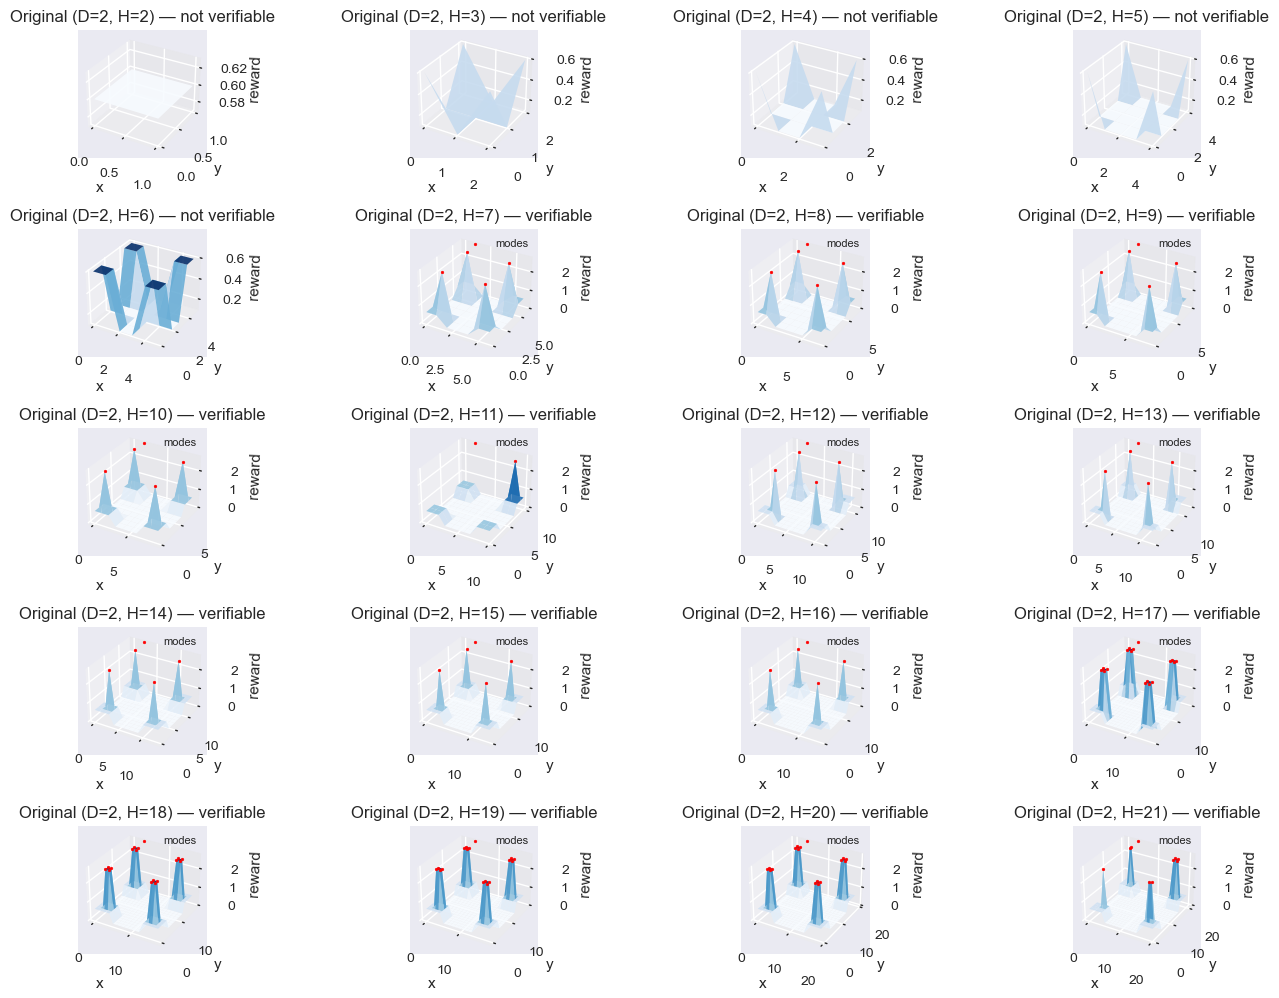

In [16]:
# Grid of Original reward landscapes for D=2 across H=2..21 with verifiability labels

fig = plt.figure(figsize=(16, 12))
Hs = list(range(2, 22))
rows, cols = 5, 4

for idx, HH in enumerate(Hs):
    ax = fig.add_subplot(rows, cols, idx + 1, projection="3d")
    reward_kwargs = dict(R0=0.1, R1=0.5, R2=2.0)

    # Check verifiability by attempting validation-enabled construction
    try:
        _ = HyperGrid(ndim=2, height=HH, reward_fn_str="original", reward_fn_kwargs=reward_kwargs, validate_modes=True, store_all_states=False)
        verifiable = True
    except Exception:
        verifiable = False

    # Build plotting env without validation to ensure the grid renders regardless
    env = HyperGrid(ndim=2, height=HH, reward_fn_str="original", reward_fn_kwargs=reward_kwargs, validate_modes=False, store_all_states=False)
    pts = grid_points_2d_slice(HH, 2)
    rewards, modes_mask = compute_rewards_and_modes(env, pts)
    tag = "verifiable" if verifiable else "not verifiable"
    plot_reward_3d(ax, f"Original (D=2, H={HH}) — {tag}", rewards, modes_mask, H=HH)

# Add more spacing to avoid label/title overlap
plt.subplots_adjust(wspace=0.35, hspace=0.55)
plt.show()
